In [1]:
%load_ext autoreload
%autoreload 1
%aimport vae
%aimport distributions
%aimport distribution_metrics
%aimport y_utils
%aimport samplers
%aimport utilities
%aimport rnvp
%aimport flow_trainer
from utilities import *
from y_utils import *
from vae import VAE, VAETrainer, get_filename
from samplers import *
from distributions import Banana, Funnel, create_gaussian_lattice, create_random_gaussian_mixture
from distribution_metrics import *
import torch
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import seaborn as sns
from rnvp import RNVP
from flow_trainer import FlowTrainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [43]:
# Target 1
lattice_shape = (3, 3)
mode_variance = 0.01
target = create_gaussian_lattice(lattice_shape, 1, mode_variance, device=device)

In [29]:
# Target 2
target = Funnel(dim=32, device=device, a=2)

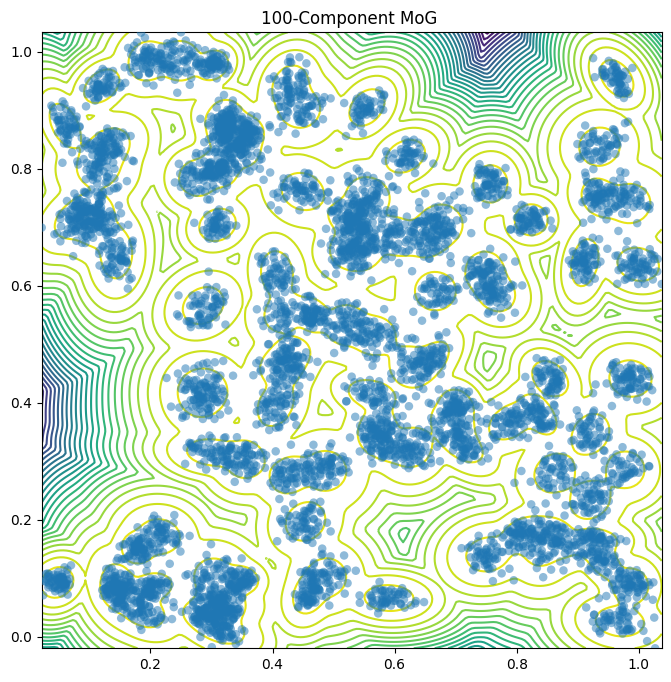

In [77]:
# Target 3
mean_lim = np.array([0, 1])
seed = 43
n_components = 100
D = 2
variance_lim = (0.0001, 0.0005)
target = create_random_gaussian_mixture(dim=D, n_components=n_components, mean_lim=mean_lim, variance_lim=variance_lim, device=device, seed=seed)
target_name = f'mog{n_components}_{D}d_vlim{variance_lim}_seed{seed}'
target_friendly_name = f'{n_components}-Component MoG'


def plot_target(N=4000, xlim=None, ylim=None, levels=30):
    plot_lim = (-0.1, 1.1)
    d = 200

    # Implementation of torch.distributions.mixture_same_family.sample() causes MemoryOverflow without batched sampling
    target_sample = sample_by_batches(target, N, batch_size=1024)
    
    fig, ax = plt.subplots(figsize=(8, 8))

    # contour plot
    if D == 2:
        if xlim is None:
            xlim = (target_sample[:, 0].min().item(), target_sample[:, 0].max().item())
        if ylim is None:
            ylim = (target_sample[:, 1].min().item(), target_sample[:, 1].max().item())
        x = torch.linspace(*xlim, d)
        y = torch.linspace(*ylim, d)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        points = torch.vstack((X.ravel(), Y.ravel()))
        Z = target.log_prob(points.T.to(device)).reshape(d, d)
        ax.contour(to_numpy(X), to_numpy(Y), to_numpy(Z), levels=levels)
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
    
    if D > 2:
        proj_dims = (0, 1)
        target_sample = target_sample[:, proj_dims]
    ax.scatter(*pl(target_sample), zorder=4, alpha=0.5, s=150, edgecolors='none', marker='.')
    ax.set_title(f'{target_friendly_name} {" (Projection)" if D > 2 else ""}')


plot_target(N=6_000)
torch.cuda.empty_cache()

In [44]:
x_train = target.sample((16_384,))

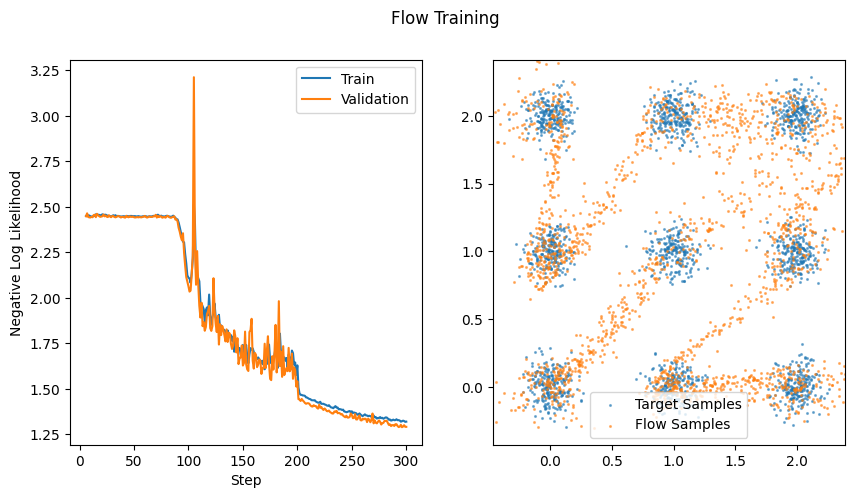

Epoch 300
	Train Loss: 1.3202
	Validation Loss: 1.2917
	Learning rate: 0.005000000000000001
CPU times: total: 1min 47s
Wall time: 1min 49s


In [50]:
%%time
flow = RNVP(num_blocks=20, dim=2, device=device)
print('Flow parameters:', count_parameters(flow))
optimizer = torch.optim.SGD(flow.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=200)
flow_trainer = FlowTrainer(flow, target, optimizer=optimizer, scheduler=scheduler, batch_size=2048, device=device)
flow_trainer.fit(x_train, n_epochs=300, plot_interval=10)

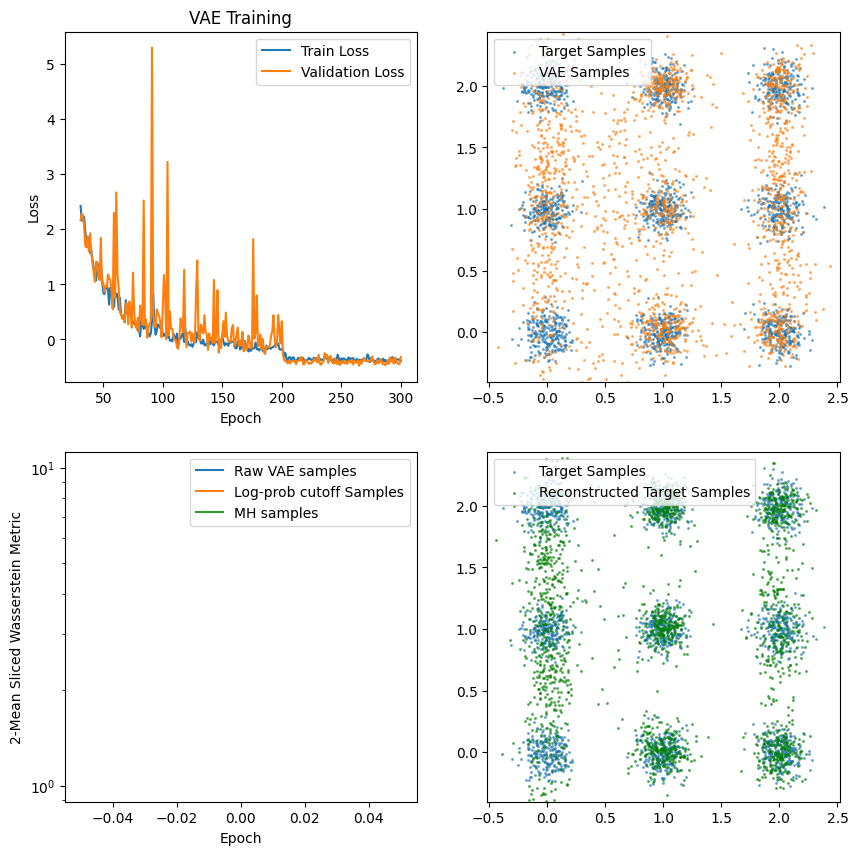

Epoch 300
	Train loss: -0.3904
	Validation loss: -0.3190
	Learning rate: 0.005000000000000001
CPU times: total: 1min 13s
Wall time: 1min 14s


In [57]:
%%time

hidden_dims = (6, 6, 6, 6, 6, 6)
vae = VAE(
    data_dim=2,
    hidden_dims=hidden_dims,
    latent_dim=6,
    device=device
) 
print('VAE parameters:', count_parameters(vae))
optimizer = torch.optim.SGD(vae.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=200)
trainer = VAETrainer(vae, target, batch_size=2048, no_kl_penalty_epochs=10, kl_annealing_epochs=100, optimizer=optimizer, scheduler=scheduler, device=device)
trainer.fit(x_train, n_epochs=300, plot_interval=10)

180